In [1]:
import os
import re
import sys

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import math

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.display import display

from copy import deepcopy
import logging as log

import pickle
import xlrd
import xlwt
import pylab

In [2]:
# Helper (support)
from support import input_helper

In [3]:
# Directory with IGU datasets:
ROOT_DIR = "RawData"

# Specify path to dynamic stock model and to datafile, relative
MainPath = os.path.join('odym', 'modules')
DataPath = os.path.join('docs', 'files')
sys.path.insert(0, MainPath)  # add ODYM module directory to system path

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))
sys.path.insert(0, os.path.join(os.getcwd(), 'docs', 'files'))

# Define path to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\03_MFA_IGU_Stock\outputs\IMG


In [4]:
import ODYM_Classes as msc  # import the ODYM class file
import ODYM_Functions as msf  # import the ODYM function file
import dynamic_stock_model as dsm  # import the dynamic stock model library

In [5]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)

In [6]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [7]:
pd.set_option('precision', 2)

In [8]:
# A custom formatter function which divide by 1000 an axis:
import matplotlib.ticker as tkr


def yfmt1000(x, pos):
    s = f'{x/1000:,.0f}'
    return s

# W/ classes for tick-locating and -formatting:


# A formatter function:
y_1000 = tkr.FuncFormatter(yfmt1000)

# To divide the y-axis by 1000 when needed:
# ax.yaxis.set_major_formatter(y_1000)

In [9]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [10]:
# A keyword to export figures, or not:
export = False

# Upload Datasets

In [11]:
# Belgian dataset:
be_data = input_helper.get_data(
    'BE_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)

# French dataset:
fr_data = input_helper.get_data(
    'FR_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)

# European dataset:
eu_data = input_helper.get_data(
    'eu_igu_RawData_VPython.xlsx', directory=ROOT_DIR)

In [12]:
print("be_data, sheet names = \n {}\n".format(be_data.sheet_names))
print("fr_data, sheet names = \n {}\n".format(fr_data.sheet_names))
print("eu_data, sheet names = \n {}\n".format(eu_data.sheet_names))

be_data, sheet names = 
 ['References', 'consumption', 'prod', 'import', 'export', 'thickness', 'Energy_Intensity', 'Population']

fr_data, sheet names = 
 ['References', 'consumption', 'prod', 'import', 'export', 'Population', 'thickness', 'RawMat_Intensity', 'Energy_Intensity', 'emissions']

eu_data, sheet names = 
 ['References', 'stock', 'prod', 'import', 'export', 'thickness', 'emissions', 'Energy_Intensity']



# Flows of Insulating Glass Units in Europe

See: Souviron J and A Stephan. (Forthcoming). "A Retrospective Analysis of the Environmental Footprint of Insulating Glass Units in the European Union, France and Belgium since 1945". _JIE_.

## Creating a Dataframe for the Flows of IGU

In [13]:
# DataFrame relating to IGU production:
df_eu_prod = eu_data.parse('prod').set_index(['Nbr of countries', 'year'])
df_eu_imp = eu_data.parse('import').set_index(['Nbr of countries', 'year'])
df_eu_exp = eu_data.parse('export').set_index(['Nbr of countries', 'year'])

In [14]:
# Create a single dataframe for flows of IGU in the EU:
df_eu = pd.concat([df_eu_prod['IGU, "000 m²']/1000,
                   df_eu_imp['IGU, "000 m²']/1000,
                   df_eu_exp['IGU, "000 m²']/1000,
                   ],
                  axis=1, keys=[('Production', '[10^6 m²]'),
                                ('Import', '[10^6 m²]'),
                                ('Export', '[10^6 m²]')
                                ],
                  names=['Info', 'Unit']).stack(dropna=False)

df_eu = df_eu.unstack()

In [15]:
# DataFrame relating to IGU avrage thickness:
df_eu_thick = eu_data.parse('thickness').set_index(
    ['Nbr of countries', 'year'])

# Linear interpolation according to available data:
df_eu_thick = (df_eu_thick.interpolate(method="linear", limit_area='inside'))

In [18]:
# Adding columns for IGU flows in [kt],
# to be used later for material/energy/carbon intensity

for level in ['average', 'min.', 'max.']:
    for flow in ['Import', 'Export', 'Production']:
        df_eu[(f'{flow}', f'[kt], {level}')] = (
            df_eu[(f'{flow}', '[10^6 m²]')] *
            df_eu_thick[f'{level} thickness, mm'] * 2.5)
        
df_eu = df_eu.sort_index(axis=1)

## Consumption of Insulating Glass Units

In [19]:
# Estimate the consumption of IGU in the EU:
df_eu = df_eu.stack(dropna=False)

df_eu['Consumption'] = (df_eu['Production']
                        + df_eu['Import']
                        - df_eu['Export']
                        )

df_eu = df_eu.unstack()

## Summary

In [28]:
# Key dates for the changes in the MFA scope, i.e. EU enlargement:
EU_KDATES = {'EU9': 1972, 'EU12': 1986,
             'EU15': 1995, 'EU27': 2003, 'EU28': 2012}

# Number of countries for trend curves:
EU_COUNTRIES = [(6, 12), (15, 15), (27, 28)]

Hypothesis for missing data: EU production = EU consumption

In [29]:
df_eu = df_eu.stack(dropna=False)
df_eu['Estimated consumption'] = (df_eu['Consumption']
                                  .fillna(df_eu['Production']))

df_eu = df_eu.unstack()

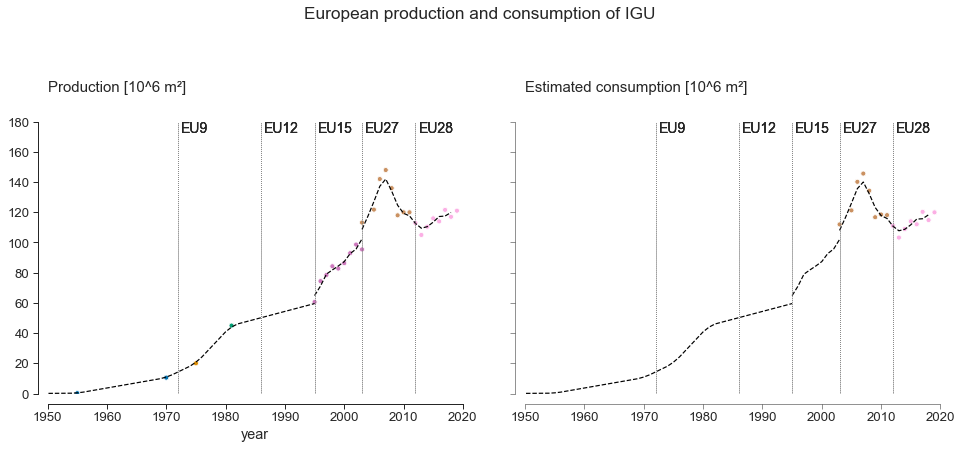

In [30]:
# Plot two figures:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, data in enumerate(['Production', 'Estimated consumption']):
    for i, j in EU_COUNTRIES:
        ax = axes[col]
        # Plot the trend curve for IGU production:
        ax.plot(df_eu.interpolate().rolling(3, center=True).mean().loc[i:j]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{data}", "[10^6 m²]")],
                c='black', linestyle='--')

        if col == 0:
            # Plot data gathered from literature review:
            sns.scatterplot(data=df_eu["Production"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)
        else:
            # Plot data gathered from literature review:
            sns.scatterplot(data=df_eu["Consumption"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)

        # Plot lines highlighting changes in the scope, i.e., EU enlargement:
        for y, x in EU_KDATES.items():
            ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
            ax.text(x+0.5, 180, f"{y}", fontsize=14,
                    verticalalignment='top')

        ax.get_legend().remove()
        ax.set_title(f'{data} [10^6 m²]', pad=30, loc='left')
        ax.yaxis.label.set_visible(False)

style_ax(ax)
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 180)

plt.suptitle('European production and consumption of IGU',
             weight='light', y=1.2)

fig.subplots_adjust(wspace=0.15)

sns.despine(offset=10)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig2_EU_IGUProdConso.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig2_EU_IGUProdConso.pdf'),
                bbox_inches='tight')

# Flows of Insulating Glass Units in France and Belgium

See: Souviron J and A Stephan. (Forthcoming). "A Retrospective Analysis of the Environmental Footprint of Insulating Glass Units in the European Union, France and Belgium since 1945". _JIE_.

## Creating a Dataframe for the Flows of IGUs

In [31]:
# Create a DataFrame from production datasets:
df_fr_prod = fr_data.parse('prod').set_index('year')
df_be_prod = be_data.parse('prod').set_index('year')

# Create DataFrames from import and export datasets:
df_fr_imp = fr_data.parse('import').set_index('year')
df_fr_exp = fr_data.parse('export').set_index('year')

df_be_imp = be_data.parse('import').set_index('year')
df_be_exp = be_data.parse('export').set_index('year')

# Create a DataFrame for the average thickness:
df_fr_thick = fr_data.parse('thickness').set_index('year')
df_be_thick = be_data.parse('thickness').set_index('year')

# Create a DataFrame from consumption data, Belgium only:
df_fr_use = fr_data.parse('consumption').set_index('year')
df_be_use = be_data.parse('consumption').set_index('year')

In [32]:
# Create a new DataFrame for Belgian and French IGU flows:
df_be_fr = (
    pd.concat([df_fr_use['IGU, "000 m²']/1000,
               df_fr_prod['IGU, "000 m²']/1000,
               df_fr_imp['IGU, "000 m²']/1000,
               df_fr_exp['IGU, "000 m²']/1000,
               df_be_use['IGU, kt'],
               df_be_use['IGU, "000 m²']/1000,
               df_be_prod['IGU, kt'],
               df_be_prod['IGU, "000 m²']/1000,
               df_be_imp['IGU, kt'],
               df_be_imp['IGU, "000 m²']/1000,
               df_be_exp['IGU, kt'],
               df_be_exp['IGU, "000 m²']/1000],
              axis=1,
              keys=[('Consumption', '[10^6 m²]', 'France'),
                    ('Production', '[10^6 m²]', 'France'),
                    ('Import', '[10^6 m²]', 'France'),
                    ('Export', '[10^6 m²]', 'France'),
                    ('Consumption', '[kt]', 'Belgium'),
                    ('Consumption', '[10^6 m²]', 'Belgium'),
                    ('Production', '[kt]', 'Belgium'),
                    ('Production', '[10^6 m²]', 'Belgium'),
                    ('Import', '[kt]', 'Belgium'),
                    ('Import', '[10^6 m²]', 'Belgium'),
                    ('Export', '[kt]', 'Belgium'),
                    ('Export', '[10^6 m²]', 'Belgium')],
              names=['Info', 'Unit', 'Country'])).stack(level=- 1,
                                                        dropna=False)

df_be_fr = df_be_fr.unstack()

In [33]:
# Create a DataFrame for the evolution of the population:
fr_pop = fr_data.parse('Population').set_index('year')
be_pop = be_data.parse('Population').set_index('year')

# Create a unique DataFrame for French and Belgian population:
df_be_fr_pop = pd.concat([fr_pop['Population, x1000'],
                       be_pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

df_be_fr_pop = df_be_fr_pop.unstack()

## Average glass thickness of IGUs

In [34]:
# Create a new DataFrame for average thickness, BE and FR:
df_be_fr_thick = (
    pd.concat([df_fr_thick['average thickness, mm'],
               df_be_thick['average thickness, mm'], ],
              axis=1,
              keys=[('average thickness, mm', 'France'),
                    ('average thickness, mm', 'Belgium')],
              names=['Info', 'Country'])).stack(dropna=False)

df_be_fr_thick = df_be_fr_thick.unstack()

In [35]:
# Linear interpolation for the average thickness:
df_be_fr_thick = df_be_fr_thick.interpolate(method='linear',
                                            limit_area='inside')

## Post-Processing the flows of IGUs

Estimation of missing date:
- Production = consumption + export - import

- Consumption = production + import - export

In [36]:
# Estimation of missing data according to units available:
# Production:
df_be_fr['Production'] = (
    df_be_fr['Production'].fillna(
        df_be_fr['Consumption']+df_be_fr['Export']-df_be_fr['Import']))

# Consumption:
df_be_fr['Consumption'] = (
    df_be_fr['Consumption'].fillna(
        df_be_fr['Production'] + df_be_fr['Import']-df_be_fr['Export']))

df_be_fr = df_be_fr.sort_index(axis=1)

In [37]:
# Stock raw data in a new Dataframe:
df_be_fr_init = df_be_fr

For Belgium, the data is either in m², tonnes or both. To "harmonise" the time series, the missing values are estimated from the average thickness of glass per IGU:

In [38]:
# Estimation of total flows per m² according to values in kt:
for flow in ['Consumption', 'Production', 'Export', 'Import']:
    # Conditions for calculating missing data according to units available:
    has_kt = df_be_fr[(f'{flow}', '[kt]', 'Belgium')].notna()
    has_m2 = df_be_fr[(f'{flow}', '[10^6 m²]', 'Belgium')].notna()

    # Calculating missing values flows according to thickness:
    df_be_fr.loc[has_kt & ~has_m2, (
        f'{flow}', '[10^6 m²]', 'Belgium')] = (
        df_be_fr.loc[has_kt & ~has_m2, (
            f'{flow}', '[kt]', 'Belgium')]
        / df_be_fr_thick[('average thickness, mm', 'Belgium')] / 2.5)

In [39]:
# Estimation of total flows per kt according to values in m²:
for flow in ['Consumption', 'Production', 'Export', 'Import']:
    # Conditions for calculating missing data according to units available:
    has_kt = df_be_fr[(f'{flow}', '[kt]', 'Belgium')].notna()
    has_m2 = df_be_fr[(f'{flow}', '[10^6 m²]', 'Belgium')].notna()

    # Calculating flows if missing according to thickness:
    df_be_fr.loc[has_m2 & ~has_kt, (
        f'{flow}', '[kt]', 'Belgium')] = (
        df_be_fr.loc[has_m2 & ~has_kt, (
            f'{flow}', '[10^6 m²]', 'Belgium')]
        * df_be_fr_thick[('average thickness, mm', 'Belgium')] * 2.5)

In [40]:
# Estimation of missing data according to units available:
# Production:
df_be_fr['Production'] = (
    df_be_fr['Production'].fillna(
        df_be_fr['Consumption']+df_be_fr['Export']-df_be_fr['Import']))

# Consumption:
df_be_fr['Consumption'] = (
    df_be_fr['Consumption'].fillna(
        df_be_fr['Production'] + df_be_fr['Import']-df_be_fr['Export']))

df_be_fr = df_be_fr.sort_index(axis=1)

Weighing the flows of IGUs, France (i.e. from Mm² to kt):

In [41]:
# Estimating total weight of the flows of IGUs [kt], France (raw data in m²)
# to be used later for material/energy/carbon intensity
for flow in ['Consumption', 'Import', 'Export', 'Production']:
    df_be_fr[(f'{flow}', '[kt]', 'France')] = (
        df_be_fr[(f'{flow}', '[10^6 m²]', 'France')]
        * df_be_fr_thick[('average thickness, mm', 'France')] * 2.5)

## Consumption of IGU

Given the scarcity of data on the consumption of insulating glass units in France, and considering the low level of exports and imports over the study period, we assume that the production is roughly equivalent to the consumption when data is missing. Please refer to the article for a detailed discussion of this hypothesis.

In [43]:
# Estimation of missing data relating to the consumption of IGU:
for unit in ['[kt]', '[10^6 m²]']:
    df_be_fr['Consumption', unit, 'France'] = (
        df_be_fr['Consumption', unit, 'France'].fillna(
            df_be_fr['Production', unit, 'France']))

Estimation of the consumption of IGU per capita in BE and FR:

In [45]:
countries = ['Belgium', 'France']

In [46]:
# Estimating the IGU consumption per capita
for country in countries:
    df_be_fr[('Consumption', '[m²/cap]', country)] = (
        df_be_fr[('Consumption', '[10^6 m²]', country)]
        .interpolate(method='pchip', limit_area="inside")*1000
        / df_be_fr_pop[('Population [x1000]', country)]
        .interpolate(method='pchip', limit_area="inside"))

df_be_fr = df_be_fr.sort_index(axis=1)

In [47]:
df_be_fr = df_be_fr.drop('[m²/cap]', axis=1, level=1)

## Summary

In [48]:
df_be_fr['Consumption'].describe()

Unit    [10^6 m²]           [kt]        
Country   Belgium France Belgium  France
count       38.00  49.00   37.00   48.00
mean         2.99  10.11   81.52  243.50
std          1.54   5.63   42.44  137.02
min          0.00   0.00    1.02    1.29
25%          1.83   4.60   43.38  103.04
50%          3.67   9.56  100.01  222.67
75%          4.14  15.93  112.72  380.86
max          5.09  17.88  139.84  427.75

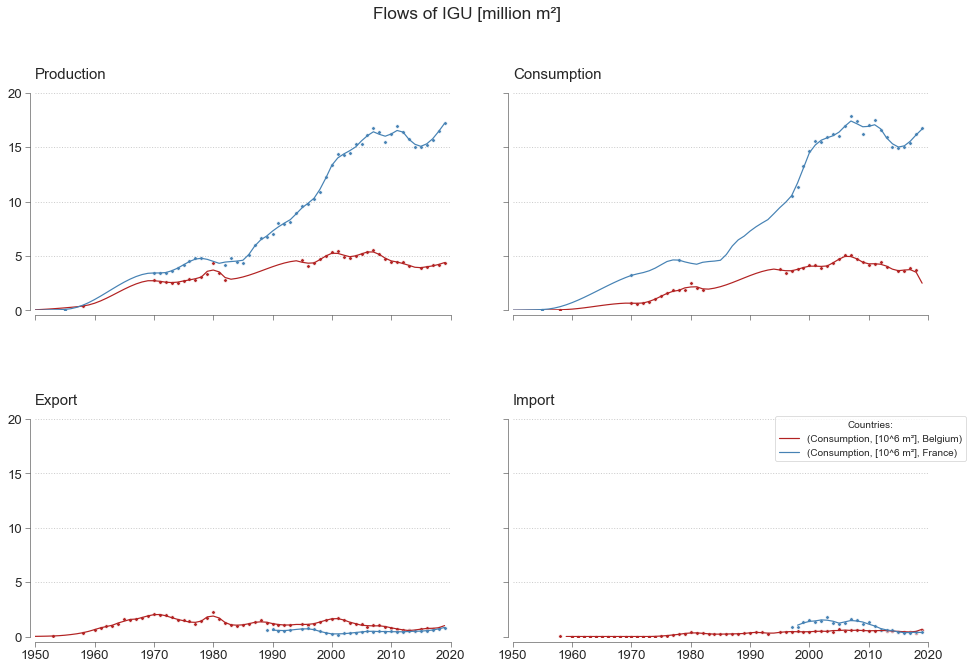

In [50]:
# Plot total flows, moving average w/ a 3-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for data in toplot:
    if data == "Production":
        ax = axes[0][0]
    if data == "Consumption":
        ax = axes[0][1]
    if data == "Export":
        ax = axes[1][0]
    if data == "Import":
        ax = axes[1][1]

    for country in countries:
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'firebrick'
            ax.set_title(f"{data}", loc='left', pad=15)
        else:
            color = 'steelblue'

        (df_be_fr[(data, "[10^6 m²]", country)]
         .interpolate(method='pchip')
         .rolling(3, center=True).mean()
         .plot(ax=ax, c=color)
         )

        # Plot raw data:
        sns.scatterplot(data=df_be_fr_init[data, "[10^6 m²]", country],
                        marker='.', s=50, color=color,
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 20)
plt.yticks(np.arange(0, 21, 5))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=1,
           title='Countries:',
           bbox_to_anchor=(0.85, 0.4))  # (0.83, 0.98)

fig.suptitle("Flows of IGU [million m²]", y=1)
sns.despine(offset=5)

plt.show()

# Dynamic Stock Modelling

See: Pauliuk, Stefan, and Niko Heeren, 2019, "ODYM—An open software framework for studying dynamic material systems: Principles, implementation, and data structures", Journal of Industrial Ecology, 24:3, 446-458.

ODYM is an open source community tool released under the MIT license and hosted on the following GitHub repository: https://github.com/indecol/odym

## Define System

In [ ]:
# Create dictionary of model classifications:
ModelClassification = {}

# Retrospective MFA from 1945 to 2020:
MyYears = list(np.arange(1945, 2021))

In [ ]:
# Classification for time labelled 'Time' must always be present,
# with Items containing a list of odered integers representing years, months,
# or other discrete time intervals:
ModelClassification['Time'] = msc.Classification(Name='Time',
                                                 Dimension='Time',
                                                 ID=1, Items=MyYears)

In [ ]:
# Classification for cohort is used to track age-cohorts in the stock:
ModelClassification['Cohort'] = msc.Classification(Name='Age-cohort',
                                                   Dimension='Time',
                                                   ID=1, Items=MyYears)

In [ ]:
# Classification for elements labelled 'Element':
ModelClassification['Element'] = msc.Classification(Name='Elements',
                                                    Dimension='Element',
                                                    ID=2, Items=['IGU'])

In [ ]:
# Classification for regions including Belgium, France and the EU:
MyRegions = ['BE', 'FR', 'EU']

ModelClassification['Region'] = msc.Classification(Name='Regions',
                                                   Dimension='Region',
                                                   ID=3, Items=MyRegions)

In [ ]:
# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

In [ ]:
Model_Duration

In [ ]:
# The indext table lists all aspects needed
# and assigns a classification and index letter to each aspect:
IndexTable = (
    pd.DataFrame(
        {'Aspect': ['Time', 'Age-cohort', 'Element', 'Region'],
         'Description': ['Model aspect "time"',
                         'Model aspect "age-cohort"',
                         'Model aspect "Element"',
                         'Model aspect "Region where flow occurs"'],
         'Dimension': ['Time', 'Time', 'Element', 'Region'],
         'Classification': ([ModelClassification[Aspect]
                             for Aspect in ['Time', 'Cohort',
                                            'Element', 'Region']]
                            ),
         'IndexLetter': ['t', 'c', 'e', 'r']
         })
)

# Default indexing of IndexTable:
IndexTable.set_index('Aspect', inplace=True)

IndexTable

In [ ]:
Dyn_MFA_System = msc.MFAsystem(Name='StockAccumulationSystem',
                               Geogr_Scope='3SelectedRegions',
                               Unit='10^6 m²',
                               ProcessList=[],
                               FlowDict={},
                               StockDict={},
                               ParameterDict={},
                               Time_Start=Model_Time_Start,
                               Time_End=Model_Time_End,
                               IndexTable=IndexTable,
                               # Initialize MFA system:
                               Elements=(IndexTable.loc['Element']
                                         .Classification.Items)
                               )

## Creating a DataFrame gathering EU, BE and FR IGU consumption flows

<font color='red'>Dataframe for IGU consumption in [10^6 m²]:</font>

In [ ]:
igu_use_m2 = (pd.DataFrame({'Year': list(np.arange(1945, 2021))})
              .set_index('Year'))

In [ ]:
igu_use_m2['EU'] = (eu_igu.droplevel(level=0)['Estimated consumption']
                    .drop(axis=1, columns='[kt]').reset_index()
                    .drop_duplicates(subset=['year'], keep='last')
                    .set_index('year'))

In [ ]:
igu_use_m2['BE'] = be_fr_igu[('Estimated consumption',
                              '[10^6 m²]', 'Belgium')]

In [ ]:
igu_use_m2['FR'] = be_fr_igu[('Estimated consumption',
                              '[10^6 m²]', 'France')]

In [ ]:
igu_use_m2['Unit'] = '[10^6 m²]'

## Formatting Data

In [ ]:
# Lifetimes:
LifetimeFile = xlrd.open_workbook(
    os.path.join(ROOT_DIR, 'IGU_Lifetime_EU_BE_FR.xlsx'))

Datasheet = LifetimeFile.sheet_by_name('Average_Lifetime')

Lifetimes = []

# Add lifetime values to list
for m in range(1, 4):
    Lifetimes.append(Datasheet.cell_value(m, 1))
print(Lifetimes)

In [ ]:
# OriginRegion x DestinationRegion x Year:
InflowArray = np.zeros((len(MyRegions), len(MyYears)))
print(InflowArray.shape)

In [ ]:
igu_use_m2.iloc[0] = 0
igu_use_m2.interpolate()[:15]

In [ ]:
# Assign the flow values to the countries:
for region in MyRegions:
    for i in igu_use_m2.index:
        OriginCountryPosition = MyRegions.index(region)
        YearPosition = MyYears.index(i)
        InflowArray[OriginCountryPosition,
                    YearPosition] = igu_use_m2[f'{region}'].interpolate().loc[i]

In [ ]:
InflowArray[0, 50]

 ## Inserting data into the MFA system

In [ ]:
# Start with empty process list,
# only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList = []
Dyn_MFA_System.ProcessList.append(msc.Process(Name='Other_industries', ID=0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name='Use phase', ID=1))

# Print list of processes:
Dyn_MFA_System.ProcessList

In [ ]:
# Define the parameter values for the inflow and yield parameters:
ParameterDict = {}

ParameterDict['Inflow'] = msc.Parameter(Name='Final IGU consumption',
                                        ID=1, P_Res=1,
                                        MetaData=None, Indices='r,t',
                                        Values=InflowArray, Unit='10^6 m²/yr')

ParameterDict['tau'] = msc.Parameter(Name='mean product lifetime',
                                     ID=2, P_Res=1,
                                     MetaData=None, Indices='r',
                                     Values=Lifetimes, Unit='yr')
ParameterDict['sigma'] = msc.Parameter(Name='stddev of mean product lifetime',
                                       ID=3, P_Res=1,
                                       MetaData=None, Indices='r',
                                       Values=[0.3 * i for i in Lifetimes],
                                       Unit='yr')

# Assign parameter dictionary to MFA system:
Dyn_MFA_System.ParameterDict = ParameterDict

In [ ]:
# Define the flows of the system, and initialise their values:
Dyn_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name='final consumption',
                                            P_Start=0, P_End=1,
                                            Indices='t,r,e', Values=None)

Dyn_MFA_System.FlowDict['F_1_0'] = msc.Flow(Name='Eol products',
                                            P_Start=1, P_End=0,
                                            Indices='t,c,r,e', Values=None)

Dyn_MFA_System.StockDict['S_1'] = msc.Stock(Name='IGU stock',
                                            P_Res=1, Type=0,
                                            Indices='t,c,r,e', Values=None)

Dyn_MFA_System.StockDict['dS_1'] = msc.Stock(Name='IGU stock change',
                                             P_Res=1, Type=1,
                                             Indices='t,r,e', Values=None)

In [ ]:
# Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_FlowValues()

# Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_StockValues()

In [ ]:
# Check whether flow value arrays match their indices, etc.
# See method documentation.
Dyn_MFA_System.Consistency_Check()

## Programming a solution of the MFA system

Program the model solution, making use of the dynamic_stock_model methods.
See: https://github.com/stefanpauliuk/dynamic_stock_model

In [ ]:
# Fit model parameter 'Inflow' to right shape in FlowDict:
Dyn_MFA_System.FlowDict['F_0_1'].Values[:, :, 0] = (
    Dyn_MFA_System.ParameterDict['Inflow'].Values.transpose())

In [ ]:
# Loop over all regions to determine inflow-driven stock:
for region in np.arange(0, len(MyRegions)):
    # Create helper DSM for computing the dynamic stock model:
    DSM_Inflow = (
        dsm.DynamicStockModel(
            t=np.array(MyYears),
            i=Dyn_MFA_System.ParameterDict['Inflow'].Values[region, :],
            lt={'Type': 'Normal',
                'Mean': [Dyn_MFA_System.ParameterDict['tau'].Values[region]],
                'StdDev': [Dyn_MFA_System.ParameterDict['sigma']
                           .Values[region]]})
    )

    Stock_by_cohort = DSM_Inflow.compute_s_c_inflow_driven()
    O_C = DSM_Inflow.compute_o_c_from_s_c()
    S = DSM_Inflow.compute_stock_total()
    DS = DSM_Inflow.compute_stock_change()

    Dyn_MFA_System.FlowDict['F_1_0'].Values[:, :, region, 0] = O_C
    Dyn_MFA_System.StockDict['dS_1'].Values[:, region, 0] = DS
    Dyn_MFA_System.StockDict['S_1'].Values[:, :, region, 0] = Stock_by_cohort

## Mass-balance-check

In [ ]:
Bal = Dyn_MFA_System.MassBalance()
# dimensions of balance are: time step x process x chemical element
print(Bal.shape)

# reports the sum of all absolute balancing errors by process.
print(np.abs(Bal).sum(axis=0))

## Results

In [ ]:
# select colors from the 'Paired' color map.
MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.3))

fig, ax = plt.subplots()

for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            Dyn_MFA_System.FlowDict['F_0_1'].Values[:, m, 0],
            color=MyColorCycle[m, :])

ax.set_ylabel('Inflows of IGU, 10^6 m²', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 10})

Plot the IGU stock in the different regions over time:

In [ ]:
# select colors from the 'Paired' color map.
MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.3))

fig, ax = plt.subplots()

for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            Dyn_MFA_System.StockDict['S_1'].Values[:, :, m, 0].sum(axis=1),
            color=MyColorCycle[m, :])

ax.set_ylabel('In-use stocks of IGU, 10^6 m²', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 10})

Plot the ratio of outflow over inflow, which is a measure of the stationarity of a stock, and can be interpreted as one indicator for a 'circular economy':

In [ ]:
FlowRatio = Dyn_MFA_System.FlowDict['F_1_0'].Values[:, :, :, 0].sum(axis=1) \
    / Dyn_MFA_System.FlowDict['F_0_1'].Values[:, :, 0]

# Set all ratios where reference flow F_0_1 was zero to zero, not nan.
FlowRatio[np.isnan(FlowRatio)] = 0

fig, ax = plt.subplots()
for m in range(0, len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items,
            FlowRatio[:, m] * 100, color=MyColorCycle[m, :])

ax.plot([1945, 2020], [100, 100], color='k', linestyle='--')

ax.set_ylabel('In-use stocks of IGU, 10^6 m²,', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 8})

# Estimating the material content of the IGU stocks

See: docs/ "ODYM Example and Tutorial No. 5. MaterialContent_VehicleFleet"

Key question here: How big is the material stock currently embodied in the European/Belgian/French stock IGUs, and when will this material become available for recycling (or landfilling...)?

<font color='red'> The Excels files are all located in the folder: docs/Files/"_ODYM_***.xlsx". </font >

In [ ]:
# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

## Export data to csv

<font color='red'>Dataframe for IGU consumption in [kt]:</font>

In [ ]:
igu_use_kt = (pd.DataFrame({'Year': list(np.arange(1945, 2021))})
              .set_index('Year'))

In [ ]:
igu_use_kt['EU'] = (eu_igu.droplevel(level=0)['Estimated consumption']
                    .drop(axis=1, columns='[10^6 m²]').reset_index()
                    .drop_duplicates(subset=['year'], keep='last')
                    .set_index('year'))

In [ ]:
igu_use_kt['BE'] = be_fr_igu[('Estimated consumption',
                              '[kt]', 'Belgium')]

In [ ]:
igu_use_kt['FR'] = be_fr_igu[('Estimated consumption',
                              '[kt]', 'France')]

In [ ]:
igu_use_kt['Unit'] = '[kt]'

To copy paste in "_ODYM_IGU_EstimatedConsumption" Excel file, because for the moment I do not see a better method...

In [ ]:
igu_use_kt.interpolate().to_csv('IGU_EstimatedConsumption.csv')

##  Load Config file and read model control parameters

In [ ]:
Mylog.info('### 2 - Load Config file and read model control parameters')

# Read main script parameters
# Load project-specific config file:
ProjectSpecs_Name_ConFile = '_ODYM_Config_IGU.xlsx'
Model_Configfile = xlrd.open_workbook(os.path.join(DataPath,
                                                   ProjectSpecs_Name_ConFile))

ScriptConfig = (
    {'Model Setting': (Model_Configfile.sheet_by_name('Config')
                       .cell_value(3, 3))}
)

Model_Configsheet = (
    Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario=Model_Configsheet.cell_value(3, 3)
print(Name_Scenario)

In [ ]:
# Read model control parameters
# Read control and selection parameters into dictionary
SCix = 0
# search for script config list entry
while Model_Configsheet.cell_value(SCix, 1) != 'General Info':
    SCix += 1

SCix += 2  # start on first data row
while len(Model_Configsheet.cell_value(SCix, 3)) > 0:
    ScriptConfig[Model_Configsheet.cell_value(SCix, 2)] = (
        Model_Configsheet.cell_value(SCix, 3)
    )
    SCix += 1

SCix = 0
# search for script config list entry
while Model_Configsheet.cell_value(SCix, 1) != 'Software version selection':
    SCix += 1

SCix += 2  # start on first data row
while len(Model_Configsheet.cell_value(SCix, 3)) > 0:
    ScriptConfig[Model_Configsheet.cell_value(SCix, 2)] = (
        Model_Configsheet.cell_value(SCix, 3)
    )
    SCix += 1

print(ScriptConfig)

 ## Read classification and data

In [ ]:
Mylog.info('### 3 - Read classification and data')
# This is standard for each ODYM model run.

# Read model run config data
Classfile = xlrd.open_workbook(
    os.path.join(DataPath,
                 str(ScriptConfig['Version of master classification'])
                 + '.xlsx'))

Classsheet = Classfile.sheet_by_name('MAIN_Table')
ci = 1  # column index to start with
MasterClassification = {}  # Dict of master classifications
while True:
    TheseItems = []
    ri = 10  # row index to start with
    try:
        ThisName = Classsheet.cell_value(0, ci)
        ThisDim = Classsheet.cell_value(1, ci)
        ThisID = Classsheet.cell_value(3, ci)
        ThisUUID = Classsheet.cell_value(4, ci)
        # read the first classification item
        TheseItems.append(Classsheet.cell_value(ri, ci))
    except:
        print('End of file or formatting error while reading the classification file in column ' + str(ci) + '.')
        break
    while True:
        ri += 1
        try:
            ThisItem = Classsheet.cell_value(ri, ci)
        except:
            break
        if ThisItem is not '':
            TheseItems.append(ThisItem)
    MasterClassification[ThisName] = (
        msc.Classification(Name=ThisName, Dimension=ThisDim,
                           ID=ThisID, UUID=ThisUUID, Items=TheseItems))
    ci += 1

print('Read index table from model config sheet.')
ITix = 0
while True:  # search for index table entry
    if Model_Configsheet.cell_value(ITix, 1) == 'Index Table':
        break
    else:
        ITix += 1

IT_Aspects = []
IT_Description = []
IT_Dimension = []
IT_Classification = []
IT_Selector = []
IT_IndexLetter = []
ITix += 2  # start on first data row
while True:
    if len(Model_Configsheet.cell_value(ITix, 2)) > 0:
        IT_Aspects.append(Model_Configsheet.cell_value(ITix, 2))
        IT_Description.append(Model_Configsheet.cell_value(ITix, 3))
        IT_Dimension.append(Model_Configsheet.cell_value(ITix, 4))
        IT_Classification.append(Model_Configsheet.cell_value(ITix, 5))
        IT_Selector.append(Model_Configsheet.cell_value(ITix, 6))
        IT_IndexLetter.append(Model_Configsheet.cell_value(ITix, 7))
        ITix += 1
    else:
        break

print('Read parameter list from model config sheet.')
PLix = 0
while True:  # search for parameter list entry
    if Model_Configsheet.cell_value(PLix, 1) == 'Model Parameters':
        break
    else:
        PLix += 1

PL_Names = []
PL_Description = []
PL_Version = []
PL_IndexStructure = []
PL_IndexMatch = []
PL_IndexLayer = []
PLix += 2  # start on first data row
while True:
    if len(Model_Configsheet.cell_value(PLix, 2)) > 0:
        PL_Names.append(Model_Configsheet.cell_value(PLix, 2))
        PL_Description.append(Model_Configsheet.cell_value(PLix, 3))
        PL_Version.append(Model_Configsheet.cell_value(PLix, 4))
        PL_IndexStructure.append(Model_Configsheet.cell_value(PLix, 5))
        PL_IndexMatch.append(Model_Configsheet.cell_value(PLix, 6))
        # strip numbers out of list string
        PL_IndexLayer.append(msf.ListStringToListNumbers(
            Model_Configsheet.cell_value(PLix, 7)))
        PLix += 1
    else:
        break

print('Read process list from model config sheet.')
PrLix = 0
while True:  # search for process list entry
    if Model_Configsheet.cell_value(PrLix, 1) == 'Process Group List':
        break
    else:
        PrLix += 1

PrL_Number = []
PrL_Name = []
PrL_Code = []
PrL_Type = []
PrLix += 2  # start on first data row
while True:
    if Model_Configsheet.cell_value(PrLix, 2) != '':
        try:
            PrL_Number.append(int(Model_Configsheet.cell_value(PrLix, 2)))
        except:
            PrL_Number.append(Model_Configsheet.cell_value(PrLix, 2))
        PrL_Name.append(Model_Configsheet.cell_value(PrLix, 3))
        PrL_Code.append(Model_Configsheet.cell_value(PrLix, 4))
        PrL_Type.append(Model_Configsheet.cell_value(PrLix, 5))
        PrLix += 1
    else:
        break

print('Read model run control from model config sheet.')
PrLix = 0
while True:  # search for model flow control entry
    if Model_Configsheet.cell_value(PrLix, 1) == 'Model flow control':
        break
    else:
        PrLix += 1

PrLix += 2  # start on first data row
while True:
    if Model_Configsheet.cell_value(PrLix, 2) != '':
        try:
            ScriptConfig[Model_Configsheet.cell_value(PrLix, 2)] = (
                Model_Configsheet.cell_value(PrLix, 3))
        except:
            None
        PrLix += 1
    else:
        break

In [ ]:
print('Define model classifications and select items for model classifications according to information provided by config file.')

# Dict of model classifications
ModelClassification = {}

for m in range(0, len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(
        MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(
        IT_Selector[m], len(ModelClassification[IT_Aspects[m]].Items))

    if EvalString.find(':') > -1:  # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = (
            ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop])

    elif EvalString.find('[') > -1:  # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = (
            [ModelClassification[IT_Aspects[m]].Items[i]
                for i in eval(EvalString)])

    elif EvalString == 'all':
        None
    else:
        Mylog.info('ITEM SELECT ERROR for aspect ' +
                   IT_Aspects[m] + ' were found in datafile.</br>')
        break

The following code block creates the index table for the MFA system and parses all parameter files specified into the parameter dictionary ParameterDict.

In [ ]:
# Define model index table and parameter dictionary
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

Model_Duration

In [ ]:
print('Define index table dataframe.')

IndexTable = pd.DataFrame(
    {'Aspect': IT_Aspects,
     # 'Time' and 'Element' must be present!
     'Description': IT_Description,
     'Dimension': IT_Dimension,
     'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
     # Unique one letter (upper or lower case) indices
     # to be used later for calculations.
     'IndexLetter': IT_IndexLetter}
)

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

In [ ]:
# Add indexSize to IndexTable:
IndexTable['IndexSize'] = (
    pd.Series(
        [len(IndexTable.Classification[i].Items) for i in range(
            0, len(IndexTable.IndexLetter)
        )], index=IndexTable.index)
)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = (
    [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))])

In [ ]:
# Define shortcuts for the most important index sizes:
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)

NR = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('r')].Items)

NG = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('g')].Items)

NM = len(IndexTable.Classification[IndexTable.set_index(
    'IndexLetter').index.get_loc('m')].Items)
print('Read model data and parameters.')

In [ ]:
ParameterDict = {}
for mo in range(0, len(PL_Names)):
    ParPath = os.path.join(DataPath, PL_Version[mo])
    print('Reading parameter ' + PL_Names[mo])
    # Do not change order of parameters handed over to function!
    MetaData, Values, Uncertainty = (
        msf.ReadParameterV2(ParPath, PL_Names[mo], PL_IndexStructure[mo],
                            PL_IndexMatch[mo], PL_IndexLayer[mo],
                            MasterClassification, IndexTable,
                            IndexTable_ClassificationNames,
                            ScriptConfig, Mylog, ParseUncertainty=True)
    )

    ParameterDict[PL_Names[mo]] = (
        msc.Parameter(Name=MetaData['Dataset_Name'],
                      ID=MetaData['Dataset_ID'],
                      UUID=MetaData['Dataset_UUID'],
                      P_Res=None,
                      MetaData=MetaData,
                      Indices=PL_IndexStructure[mo],
                      Values=Values,
                      Uncert=Uncertainty,
                      Unit=MetaData['Dataset_Unit'])
    )

In [ ]:
# Replicate lifetime, given for 2020 age-cohort, for all age-cohorts
ParameterDict['_ODYM_IGULifetime'].Values[0, 0, :, :] = (
    np.einsum('r,c->rc', ParameterDict['_ODYM_IGULifetime']
              .Values[0, 0, :, 20], np.ones(Nt)))

# Replicate uncertainty
for m in range(0, NR):
    for n in range(0, Nt):
        ParameterDict['_ODYM_IGULifetime'].Uncert[m*Nt + n] = (
            ParameterDict['_ODYM_IGULifetime'].Uncert[m*Nt+20])

In [ ]:
# Replicate IGU material content for all countries and age-cohorts:
ParameterDict['_ODYM_IGUMaterialContent'].Values[:, 0, :, :] = (
    np.einsum('m,rc->mrc', ParameterDict['_ODYM_IGUMaterialContent']
              .Values[:, 0, 0, 20], np.ones((NR, Nt)))
)

# Replicate uncertainty:
for m in range(0, NM):
    for r in range(0, NR):
        for t in range(0, Nt):
            (ParameterDict['_ODYM_IGUMaterialContent']
             .Uncert[m*Nt*NR + r*Nt + t]) = (
                ParameterDict['_ODYM_IGUMaterialContent']
                .Uncert[m*Nt*NR + 20])

## Define MFA system

In [ ]:
Mylog.info('### 4 - Define MFA system')
print('Define MFA system and processes.')

# Initialize MFA system
IGU_MFA_System = msc.MFAsystem(Name='Materials_IGU',
                               Geogr_Scope='Europe',
                               Unit='kt',
                               ProcessList=[],
                               FlowDict={},
                               StockDict={},
                               ParameterDict=ParameterDict,
                               Time_Start=Model_Time_Start,
                               Time_End=Model_Time_End,
                               IndexTable=IndexTable,
                               Elements=(IndexTable.loc['Element']
                                         .Classification.Items),
                               Graphical=None)

# Check Validity of index tables:
# returns true if dimensions are OK and time index is present and element list is not empty
IGU_MFA_System.IndexTableCheck()

In [ ]:
# Add processes to system
for m in range(0, len(PrL_Number)):
    IGU_MFA_System.ProcessList.append(
        msc.Process(Name=PrL_Name[m], ID=PrL_Number[m]))

In [ ]:
# Define system variables: 6 flows.
IGU_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name='IGU production',
                                            P_Start=0,
                                            P_End=1,
                                            Indices='t,g,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_1_2'] = msc.Flow(Name='IGU consumption',
                                            P_Start=1,
                                            P_End=2, Indices='t,g,r,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_2_3'] = msc.Flow(Name='Scrapping of IGU',
                                            P_Start=2,
                                            P_End=3, Indices='t,c,g,r,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_3_4'] = msc.Flow(Name='IGU scrap',
                                            P_Start=3,
                                            P_End=4, Indices='t,w,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_3_0'] = msc.Flow(Name='Recovery losses',
                                            P_Start=3,
                                            P_End=0, Indices='t,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

IGU_MFA_System.FlowDict['F_4_0'] = msc.Flow(Name='IGU scrap supply',
                                            P_Start=4,
                                            P_End=0, Indices='t,w,m,e',
                                            Values=None, Uncert=None,
                                            Color=None,
                                            ID=None, UUID=None)

In [ ]:
# Define system variables: 1 stock and 1 stock change:
IGU_MFA_System.StockDict['S_2'] = msc.Stock(Name='In-use stock',
                                            P_Res=2, Type=0,
                                            Indices='t,c,g,r,m,e',
                                            Values=None, Uncert=None,
                                            ID=None, UUID=None)

IGU_MFA_System.StockDict['dS_2'] = msc.Stock(Name='Net in-use stock change',
                                             P_Res=2, Type=1,
                                             Indices='t,g,r,m,e',
                                             Values=None, Uncert=None,
                                             ID=None, UUID=None)

In [ ]:
# Assign empty arrays to stocks according to dimensions.
IGU_MFA_System.Initialize_StockValues()

# Assign empty arrays to flows according to dimensions.
IGU_MFA_System.Initialize_FlowValues()

In [ ]:
IGU_MFA_System.IndexTable

In [ ]:
IGU_MFA_System.ParameterDict

In [ ]:
print(IGU_MFA_System.ProcessList)
print([i.Name for i in IGU_MFA_System.ProcessList])
print([i.ID for i in IGU_MFA_System.ProcessList])